<a href="https://colab.research.google.com/github/ManasaK285/AI/blob/main/DL_GANS(Generative_Adversarial_Networks).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from zipfile import ZipFile
with ZipFile('https://colab.research.google.com/drive/379764_737475_bundle_archive.zip', 'r') as zf:
    zf.extractall(path='./datadir')

FileNotFoundError: ignored

In [ ]:
DATA_DIR='./datadir'

In [ ]:
import os
print(os.listdir(DATA_DIR))

FileNotFoundError: ignored

In [ ]:
print(os.listdir(DATA_DIR+'/images')[:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
imagesize=64
batchsize=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [ ]:
train_ds=ImageFolder(DATA_DIR,transform=T.Compose([
                     T.Resize(imagesize),
                     T.CenterCrop(imagesize),
                     T.ToTensor(),
                     T.Normalize(*stats)]))

In [ ]:
train_dl=DataLoader(train_ds,batchsize,shuffle=True,num_workers=3,pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors*stats[1][0]+stats[0][0]

In [ ]:
def show_images(images,nmax=64):
    fig,ax=plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))
def show_batch(dl,nmax=64):
    for images,_ in dl:
        show_images(images,nmax)
        break

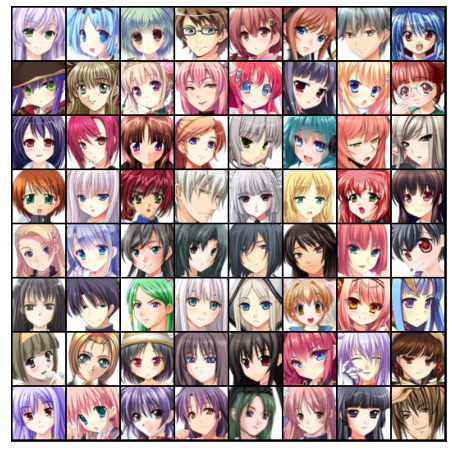

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return(len(self.dl))
def to_device(data,device):
    if isinstance(data,(list,tuple)):
                  return([to_device(x,device) for x in data])
    return data.to(device,non_blocking=True)

In [ ]:
device=get_default_device()
device

device(type='cpu')

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
discriminator=nn.Sequential(

              nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(64),
              nn.LeakyReLU(0.2,inplace=True),

              nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(128),
              nn.LeakyReLU(0.2,inplace=True),

              nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(256),
              nn.LeakyReLU(0.2,inplace=True),

              nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(512),
              nn.LeakyReLU(0.2,inplace=True),

              nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),

              nn.Flatten(),
              nn.Sigmoid())

In [ ]:
discriminator=to_device(discriminator,device)

In [ ]:
latentsize=128

In [ ]:
generator=nn.Sequential(

              nn.ConvTranspose2d(latentsize,512,kernel_size=4,stride=1,padding=0,bias=False),
              nn.BatchNorm2d(512),
              nn.ReLU(True),

              nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(256),
              nn.ReLU(True),

              nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(128),
              nn.ReLU(True),

              nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(64),
              nn.ReLU(True),

              nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
              nn.Tanh())

torch.Size([128, 3, 64, 64])


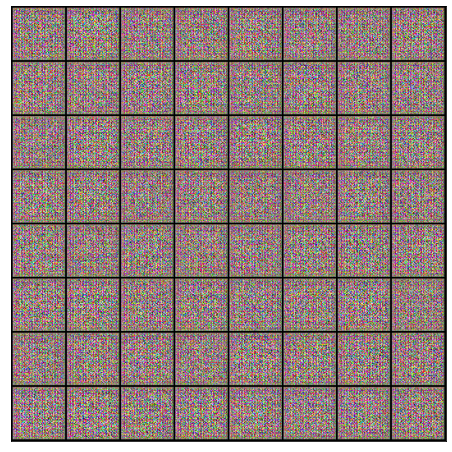

In [ ]:
xb=torch.randn(batchsize,latentsize,1,1)
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator=to_device(generator,device)

In [ ]:
def train_discriminator(real_images,opt_d):
    #clear discriminator gradients
    opt_d.zero_grad()

    #pass real images throgh discriminator
    real_preds=discriminator(real_images)
    real_targets=torch.ones(real_images.size(0),1,device=device)
    real_loss=F.binary_cross_entropy(real_preds,real_targets)
    real_score=torch.mean(real_preds).item()

    #generate fake images
    latent=torch.randn(batchsize,latentsize,1,1,device=device)
    fake_images=generator(latent)


    #pass fake images through discriminator
    fake_targets=torch.zeros(fake_images.size(0),1,device=device)
    fake_preds=discriminator(fake_images)
    fake_loss=F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score=torch.mean(fake_preds).item()

    #update discriminator weights
    loss=real_loss+fake_loss
    loss.backward()
    opt_d.step()#only affects discriminator parameters(while training discriminator, generator is usually frozen)
    return loss.item(),real_score,fake_score


In [ ]:
def train_generator(opt_g):
    #clear generator gradients
    opt_g.zero_grad()

    #generate fake images
    latent=torch.randn(batchsize,latentsize,1,1,device=device)
    fake_images=generator(latent)

    #try to fool discriminator
    preds=discriminator(fake_images)
    targets=torch.ones(batchsize,1,device=device)
    loss=F.binary_cross_entropy(preds,targets)

    #update generator weights

    loss.backward()
    opt_g.step()
    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir='generated'
os.makedirs(sample_dir,exist_ok=True)

In [ ]:
def save_samples(index,latent_tensors,show=True):
    fake_images=generator(latent_tensors)
    fake_fname='generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
    print('Saving',fake_fname)
    if show:
        fig,ax=plt.subplots(figsize=(8,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

In [ ]:
fixed_latent=torch.randn(64,latentsize,1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


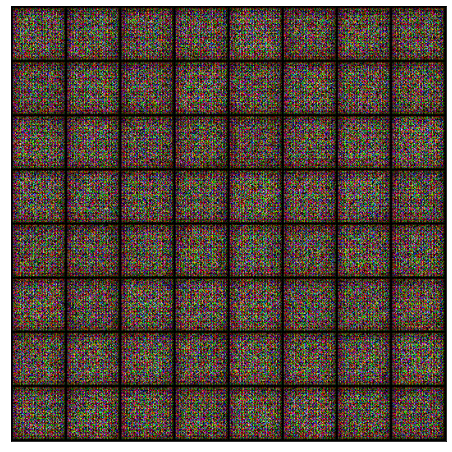

In [ ]:
save_samples(0,fixed_latent)

In [ ]:
#!pip install tqdm
from tqdm import tqdm

In [ ]:
def fit(epochs,lr,start_idx=1):

    losses_g=[]
    losses_d=[]
    real_scores=[]
    fake_scores=[]

    opt_d=torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
    opt_g=torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images,_ in tqdm(train_dl):
            loss_d,real_score,fake_score=train_discriminator(real_images,opt_d)
            loss_g=train_generator(opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)


        print('Epoch[{}/{}],loss_g:{:.4f},loss_d:{:.4f},real_score:{:.4f},fake_score:{:.4f}'.format(
        epoch+1,epochs,loss_g,loss_d,real_score,fake_score))

        save_samples(epoch+start_idx,fixed_latent,show=False)
    return losses_g,losses_d,real_scores,fake_scores

In [ ]:
lr=0.0002
epochs=5

In [ ]:
history=fit(epochs,lr)

 26%|██▌       | 128/497 [25:08<1:12:27, 11.78s/it]


KeyboardInterrupt: 

In [ ]:
losses_g,losses_d,real_scores,fake_scores=history

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0000.png')

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0002.png')

In [ ]:
Image('./generated/generated-images-0003.png')

In [ ]:
Image('./generated/generated-images-0004.png')

In [ ]:
Image('./generated/generated-images-0005.png')

In [ ]:
plt.plot(losses_d,'-')
plt.plot(losses_g,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('losses')